In [1]:
import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import time 
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### trainining modules

In [131]:
from model_baseline import ConvCNP_Multi
from model_latent_baseline import ConvCNP_Latent_Multi

from model_proposed_new_v1 import ConvCNP_Multi_CC
from model_proposed_new_v2 import ConvCNP_Multi_CC as ConvCNP_Multi_CCC
from convcnp.architectures import SimpleConv, UNet, UNet_Depth3

from train_loss import compute_nll,compute_nll_latent    


#--------------------------------
#tarining config
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nchannels = 3
in_channels = nchannels


iscuda = True
lr = 5e-4
weight_decay = 1e-4
points_per_unit = 64
nbasis = 5
init_l = 0.01




base_model_list = ['convcnp','convcnp_d6']    
latent_model_list = ['convcnp_latent','convcnp_d6_latent']    

def build_model(model_type):
    if model_type == 'convcnp':
        model = ConvCNP_Multi(in_channels=in_channels,
                              rho = UNet_Depth3(in_channels**2),
                              points_per_unit=points_per_unit,
                              rbf_init_l= init_l,
                              nbasis = nbasis)
    
    if model_type == 'convcnp_d6':
        model = ConvCNP_Multi(in_channels=in_channels,
                              rho = UNet(in_channels**2),
                              points_per_unit=points_per_unit,
                              rbf_init_l= init_l,
                              nbasis = nbasis)

    
    if model_type == 'convcnp_latent':
        model = ConvCNP_Latent_Multi( in_channels=in_channels,
                                      rho = UNet_Depth3(in_channels**2),
                                      points_per_unit=points_per_unit,
                                      rbf_init_l= init_l,
                                      nbasis = nbasis)

    if model_type == 'convcnp_d6_latent':
        model = ConvCNP_Latent_Multi( in_channels=in_channels,
                                      rho = UNet(in_channels**2),
                                      points_per_unit=points_per_unit,
                                      rbf_init_l= init_l,
                                      nbasis = nbasis)


    elif model_type == 'pro-nv2':        
        model = ConvCNP_Multi_CC(in_channels=in_channels,
                               rho = UNet_Depth3(in_channels**2),
                               cc_rho = UNet_Depth3(in_channels**2),
                               points_per_unit=points_per_unit,
                               rbf_init_l= init_l,
                               nbasis = nbasis)

    elif model_type == 'pro-nv22':        
        model = ConvCNP_Multi_CCC(in_channels=in_channels,
                               rho = UNet_Depth3(in_channels**2),
                               cc_rho = UNet_Depth3(in_channels**2),
                               points_per_unit=points_per_unit,
                               rbf_init_l= init_l,
                               nbasis = nbasis)
        
    elif model_type == 'anp':
        model = RegressionANP(input_dim=nchannels,
                              latent_dim=128,
                              num_channels=nchannels)        
        
        

    elif model_type == 'cnp':
        model = RegressionCNP(input_dim=nchannels,
                              latent_dim=128,
                              num_channels=nchannels)
    else:
        pass
    

    if iscuda:
        model = model.cuda()
    opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
    
    
    return model,opt
    

    
    

def train_epochs_with_dict(set_dict_epoch,model,opt,trainmodel='convcnp'):
    model.train()
    likelihoods = []
    
    ntask = set_dict_epoch['context_x'].size(0)
    for ith in range(ntask):
                
        context_x,context_y = set_dict_epoch['context_x'][ith],set_dict_epoch['context_y'][ith]
        target_x,target_y = set_dict_epoch['target_x'][ith],set_dict_epoch['target_y'][ith]

        
        # predict & train models
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())        
        if trainmodel in base_model_list:
            obj = compute_nll( y_mean,y_std, target_y.cuda())
                        
        if trainmodel in latent_model_list:
            #y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())
            obj = compute_nll_latent( y_mean, y_std, target_y.cuda())
    
    
        # Optimization
        obj.backward()
        opt.step()
        opt.zero_grad()
        
        #losses.append(obj.item())
        likelihoods.append(obj.cpu().data.numpy())        
        
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       




def validate_epochs_with_dict(set_dict_epoch,model,test_range=None,trainmodel='convcnp'):
    # large is better 
    model.eval()
    likelihoods = []
    
    ntask = set_dict_epoch['context_x'].size(0)    
    for ith in range(ntask):        
        
        context_x,context_y = set_dict_epoch['context_x'][ith],set_dict_epoch['context_y'][ith]
        target_x,target_y = set_dict_epoch['target_x'][ith],set_dict_epoch['target_y'][ith]
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())

        if trainmodel in base_model_list:
            #y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())
            obj = -compute_nll( y_mean,y_std, target_y.cuda())
               
        if trainmodel in latent_model_list:
            obj = -compute_nll_latent( y_mean, y_std, target_y.cuda())
            
            
        likelihoods.append(obj.cpu().data.numpy())        
                
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       






#def validate_epochs(set_dict_epoch,model,test_range=None,trainmodel='convcnp'):
def validate_epochs(gen_cls,model,ntask=128,nbatch=32,ncontext=32,ntarget=2*32,train_range= None,test_range=None,intrain=True,trainmodel='convcnp'):
    
    # large is better 
    model.eval()
    likelihoods = []
    
    #ntask = set_dict_epoch['context_x'].size(0)    
    for _ in range(int(ntask)):            
        context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                                   ncontext=ncontext,
                                                                                   ntarget=ntarget,
                                                                                   train_range=gen_cls.train_range,
                                                                                   test_range=gen_cls.test_range,
                                                                                   noise_true= True,
                                                                                   intrain = intrain)
        
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())
        if trainmodel in base_model_list:
            #y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())
            obj = -compute_nll( y_mean,y_std, target_y.cuda())
               
        if trainmodel in latent_model_list:
            obj = -compute_nll_latent( y_mean, y_std, target_y.cuda())
            
            
        likelihoods.append(obj.cpu().data.numpy())        
                
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       
    

In [132]:
#-------------------------------------------
# train
#------------------------------------------
tasktype = 'sin3'
#tasktype = 'lmc' #lmc
#tasktype = 'mosm' #lmc

dep = True
testtype = 'extra'
#testtype = 'inter'



In [133]:
from dataset_multi import motask_generator
import time

if testtype == 'inter':
    train_range = [-4,4]
    test_range = [-2,2]
    gen_cls = motask_generator(tasktype=tasktype,testtype=testtype,nchannels=nchannels,train_range=train_range,test_range=test_range,dep=dep)

elif testtype == 'extra':
    #train_range,test_range = [-2,2],[-4,4]    
    train_range,test_range = [0,5],[0,10]
    gen_cls = motask_generator(tasktype=tasktype,testtype=testtype,nchannels=nchannels,train_range=train_range,test_range=test_range,dep=dep)
else:
    pass


In [134]:
#nepochs = 100
#nepochs = 300
#nepochs = 200
#nepochs = 20
nepochs = 400

In [135]:
#load_dict.keys()

In [136]:
#from multitask_kernel_v4_sin3_withpaper_v2 import build_model
#nepochs = 400
#nepochs = 400

#model_type='convcnp'
model_type='convcnp_d6'

model_convcnp,_ = build_model(model_type=model_type)
#saved_modelparam_path = './param_{}/modeltype{}_trainlossuniform_nepochs{}_lr0.0005.pth'.format(tasktype,model_type,nepochs)
saved_modelparam_path = './param_{}/modeltype{}_nepochs{}_lr0.0005.pth'.format(tasktype,model_type,nepochs)

load_dict = torch.load(saved_modelparam_path)
print('load_dict with {}'.format(model_type))
print(load_dict['epoch'],load_dict['best_acc_top1'])
model_convcnp.load_state_dict(load_dict['state_dict'])       


# model_type='propose_n_v1'
# model_tmp,_ = build_model(model_type=model_type)
# saved_modelparam_path = './param_sin3/modeltype{}_trainlossuniform_nepochs200_lr0.0005.pth'.format(model_type)
# load_dict = torch.load(saved_modelparam_path)
# model_tmp.load_state_dict(load_dict['state_dict'])       

#modeltypeconvcnp_trainlossuniform_nepochs400_lr0.0005
#nepochs = 400

#model_type='pro-nv2'
#model_type='pro-nv22'
#saved_modelparam_path = './param_{}/modeltype{}_trainlossuniform_nepochs{}_lr0.0005.pth'.format(tasktype,model_type,nepochs)
#nepochs = 200

#model_type='convcnp_latent'
model_type='convcnp_d6_latent'

saved_modelparam_path = './param_{}/modeltype{}_nepochs{}_lr0.0005.pth'.format(tasktype,model_type,nepochs)

model_tmp,_ = build_model(model_type=model_type)

load_dict = torch.load(saved_modelparam_path)
print('load_dict with {}'.format(model_type))
print(load_dict['epoch'],load_dict['best_acc_top1'])
model_tmp.load_state_dict(load_dict['state_dict'])       
#modeltypepro-nv2_trainlossuniform_nepochs400_lr0.0005.pth


load_dict with convcnp_d6
317 -96.24
load_dict with convcnp_d6_latent
386 -74.58


<All keys matched successfully>

In [137]:
#ncontext=10
# ncontext_list = [10,20,30,50]
# ntarget=100

ntask = 4
nbatch = 16


# ntarget=100
# ncontext_list = [10,20,25,30,40]


ntarget=50
ncontext_list = [10,20,25,30]

#ncontext_list = [40,50]

#ntarget=50

#ntask = 120

for ncontext in ncontext_list :
    #print('ncontext {}, ntarget {}'.format(ncontext,ntarget))
    print('#----------------------------------------------------')
    print('convcnp: ntask {}, nbatch {}, ncontext {}, ntarget {}'.format(ntask,nbatch,ncontext,ntarget))
    inrange_train_m,inrange_train_s = validate_epochs(gen_cls,model_convcnp,ntask=ntask,nbatch=16,ncontext=ncontext,ntarget=ntarget,intrain=True,trainmodel='convcnp')
    outrange_train_m,outrange_train_s = validate_epochs(gen_cls,model_convcnp,ntask=ntask,nbatch=16,ncontext=ncontext,ntarget=ntarget,intrain=False,trainmodel='convcnp')
    print('intrain testset | val_mnll_mean {:.3f}, val_mnll_std {:.3f}'.format(inrange_train_m,inrange_train_s))           
    print('outtrain testset | te_mnll_mean {:.3f}, te_mnll_std {:.3f}'.format(outrange_train_m,outrange_train_s  ))           

    print('#----------------------------------------------------')
    print('pro-nv2: ntask {}, nbatch {}, ncontext {}, ntarget {}'.format(ntask,nbatch,ncontext,ntarget))    
    inrange_train_m,inrange_train_s = validate_epochs(gen_cls,model_tmp,ntask=ntask,nbatch=16,ncontext=ncontext,ntarget=ntarget,intrain=True,trainmodel='convcnp_latent')
    outrange_train_m,outrange_train_s = validate_epochs(gen_cls,model_tmp,ntask=ntask,nbatch=16,ncontext=ncontext,ntarget=ntarget,intrain=False,trainmodel='convcnp_latent')
    print('intrain testset | val_mnll_mean {:.3f}, val_mnll_std {:.3f}'.format(inrange_train_m,inrange_train_s))           
    print('outtrain testset | te_mnll_mean {:.3f}, te_mnll_std {:.3f}'.format(outrange_train_m,outrange_train_s  ))           
    print('\n')
    


#----------------------------------------------------
convcnp: ntask 4, nbatch 16, ncontext 10, ntarget 50
intrain testset | val_mnll_mean -97.650, val_mnll_std 2.850
outtrain testset | te_mnll_mean -93.870, te_mnll_std 3.120
#----------------------------------------------------
pro-nv2: ntask 4, nbatch 16, ncontext 10, ntarget 50
intrain testset | val_mnll_mean -79.800, val_mnll_std 5.770
outtrain testset | te_mnll_mean -76.630, te_mnll_std 4.430


#----------------------------------------------------
convcnp: ntask 4, nbatch 16, ncontext 20, ntarget 50
intrain testset | val_mnll_mean -52.280, val_mnll_std 0.570
outtrain testset | te_mnll_mean -56.860, te_mnll_std 1.490
#----------------------------------------------------
pro-nv2: ntask 4, nbatch 16, ncontext 20, ntarget 50
intrain testset | val_mnll_mean -13.150, val_mnll_std 1.930
outtrain testset | te_mnll_mean -19.610, te_mnll_std 1.800


#----------------------------------------------------
convcnp: ntask 4, nbatch 16, ncontext 

## computations checks

In [138]:
import warnings
warnings.filterwarnings('ignore')

color_list = ['red','blue','green']
figsiz_ = (24,3.8)


In [139]:
#y_mean1.size()

In [140]:
# train_range_p = [0,5]
# test_range_p = [0,10]



#train_range_p = [[0,3],[2,5],[4,7]]
#train_range_p = [[0,4],[1,5],[4,7]]
train_range_p = [[0,4],[3,7],[5,9]]

test_range_p = [0,10]

In [141]:
#y_mean1[0]

## draw figures 

####################################################################################################


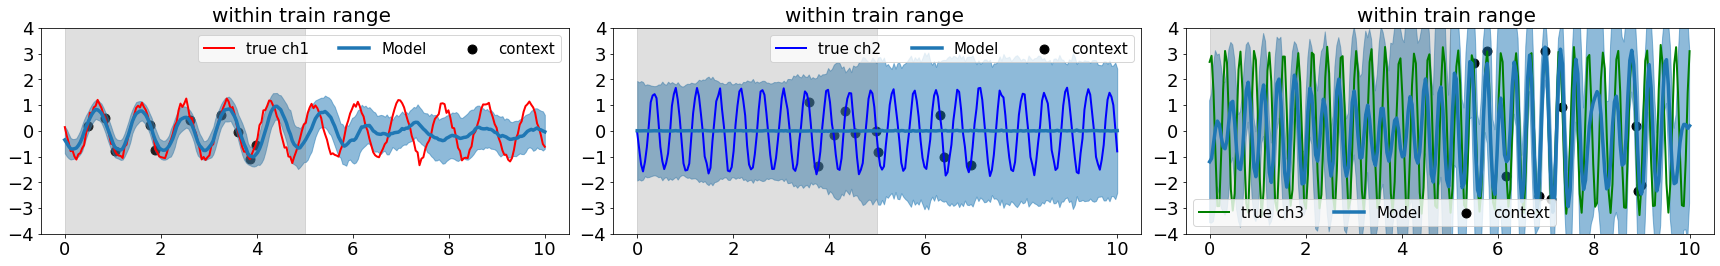

####################################################################################################


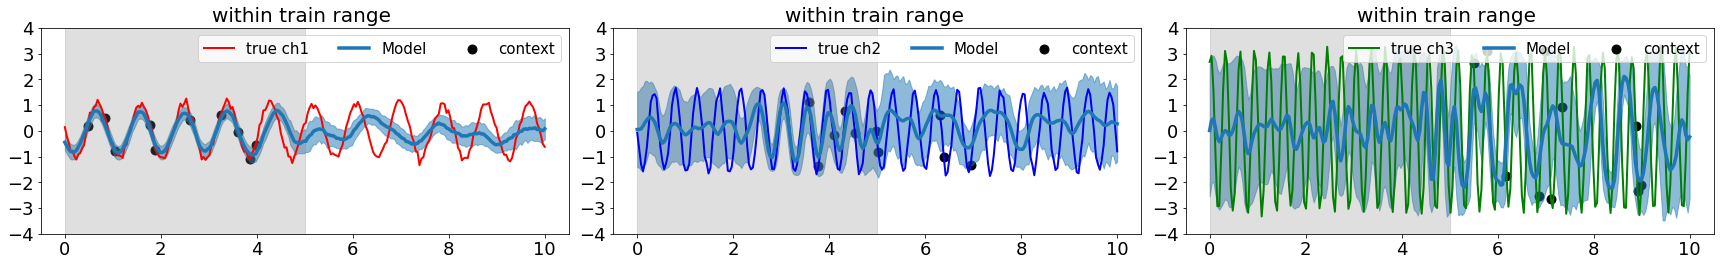

In [224]:
from model_gpbaseline import validate_oracle_epochs_with_dict,gp_predict_batch

# def gaussian_sampler(mu,std,num_sample =5):
#     sample_list = []
#     for i in range(num_sample):
#         tmp = mu + std*torch.randn_like(std)
#         sample_list.append(tmp[None,:,:])
#     return torch.cat(sample_list,dim=0).squeeze()

#xlim_ = [0-0.1,10+0.1]

train_range = gen_cls.train_range
test_range = gen_cls.test_range


nbatch=1
#xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
xlim_ = [gen_cls.full_range[0]-0.5,gen_cls.full_range[1]+0.5]
#ylim_ = [-2,2]
ylim_ = [-4,4]

alpha_=0.5

fontsiz_ = 15
fontsiz__ = 18

context_marker = 80
#------------------------------------------------------
# intrain context
#------------------------------------------------------
#ncontext,ntarget = 8,42
ncontext,ntarget = 10,50

#gen_cls.testtype = 'extra'
gen_cls.testtype = testtype
# context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
#                                                                          ncontext=ncontext,
#                                                                          ntarget=ntarget,
#                                                                          train_range = train_range,
#                                                                          test_range = test_range,                                                                         
#                                                                          noise_true= True,
#                                                                          intrain = True)

context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range_p,
                                                                         test_range = test_range_p,                                                                         
                                                                         noise_true= True,
                                                                         intrain = True)



model_convcnp.eval()
model_tmp.eval()

y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0,0],y_std1.cpu().data.numpy()[0,0]


context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=context_marker,label = 'context') #,marker='s'
        
        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=2.0,label = 'true ch{}'.format(j+1) )    
        #plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
#y_mean,y_std = y_mean1_1,y_std1_1
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=context_marker,label = 'context') #,marker='s'

        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=2.0,label = 'true ch{}'.format(j+1) )    
        #plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model       
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




####################################################################################################


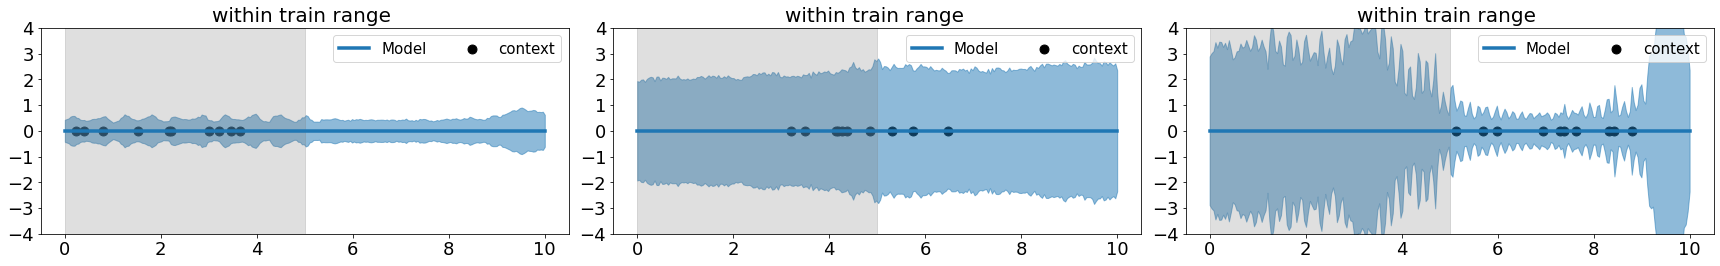

####################################################################################################


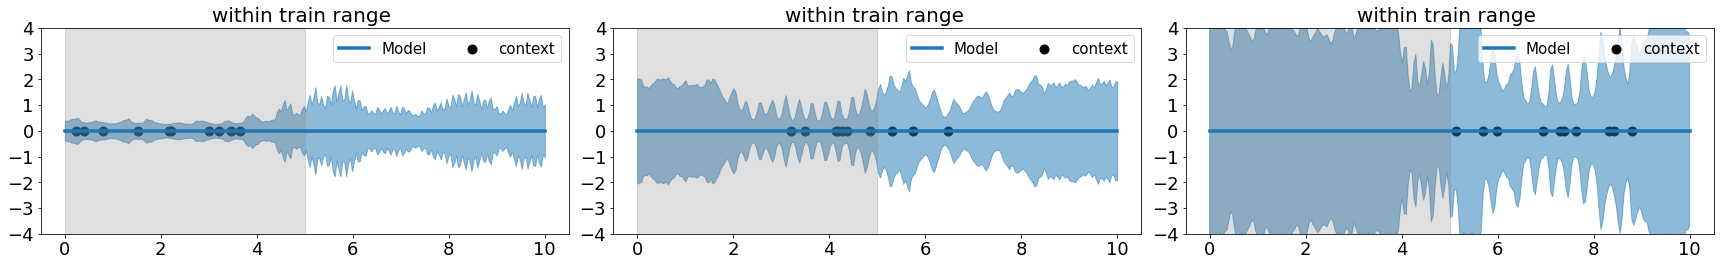

In [210]:
#y_std1_1.shape
from model_gpbaseline import validate_oracle_epochs_with_dict,gp_predict_batch

# def gaussian_sampler(mu,std,num_sample =5):
#     sample_list = []
#     for i in range(num_sample):
#         tmp = mu + std*torch.randn_like(std)
#         sample_list.append(tmp[None,:,:])
#     return torch.cat(sample_list,dim=0).squeeze()

# #xlim_ = [0-0.1,10+0.1]
# color_list = ['red','blue','green']

# figsiz_ = (24,3.8)

# train_range = gen_cls.train_range
# test_range = gen_cls.test_range
# nbatch=2
# #xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
# xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
# #ylim_ = [-2,2]
# #ylim_ = [-4,4]
# alpha_=0.4

# fontsiz_ = 15
# fontsiz__ = 18

# #------------------------------------------------------
# # intrain context
# #------------------------------------------------------
# #ncontext,ntarget = 8,42
# #ncontext,ntarget = 5,100

# #gen_cls.testtype = 'extra'
# gen_cls.testtype = testtype
# context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
#                                                                          ncontext=ncontext,
#                                                                          ntarget=ntarget,
#                                                                          train_range = train_range,
#                                                                          test_range = test_range,                                                                         
#                                                                          noise_true= False,
#                                                                          intrain = True)




# # y_mean0, y_std0 = gp_predict_batch(context_x,context_y,full_x, Ksub=gen_cls.f.Ksub, diag = True)
# # y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]

# model.eval()
# y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda())
# y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0],y_std1.cpu().data.numpy()[0]

# y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())


context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=context_marker,label = 'context') #,marker='s'
        
#         #true
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model
        plt.plot(full_x_1[:,j],0*y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0*y_mean[:,j] + 2 * y_std[:,j],
                         0*y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=context_marker,label = 'context') #,marker='s'
        
#         #true
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model
        plt.plot(full_x_1[:,j],0*y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0*y_mean[:,j] + 2 * y_std[:,j],
                         0*y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)
        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()



####################################################################################################


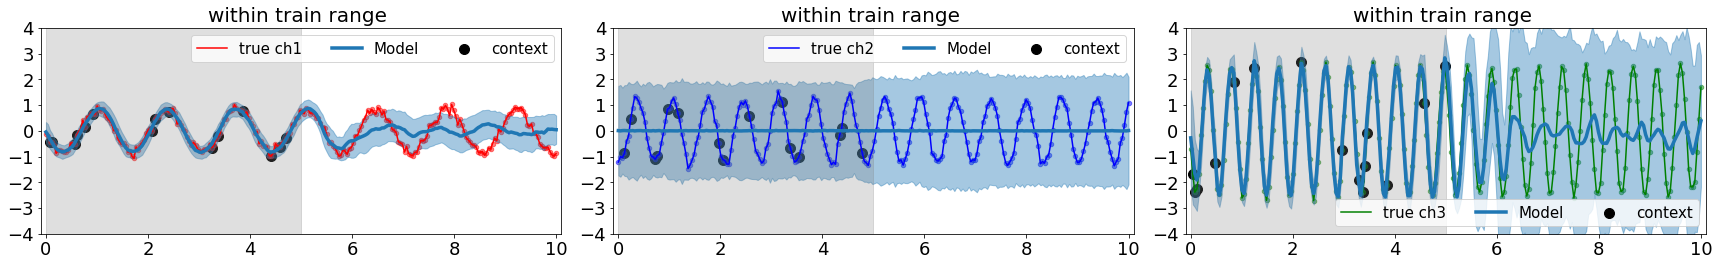

####################################################################################################


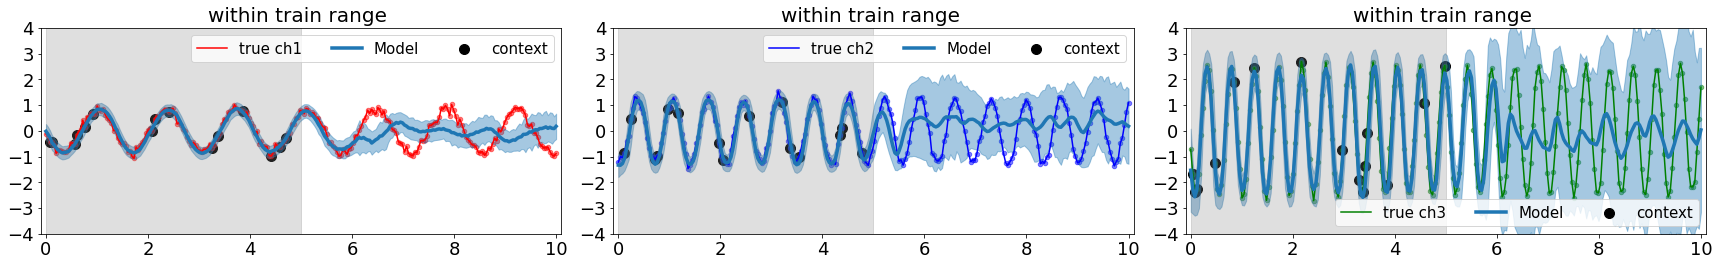

In [211]:
from model_gpbaseline import validate_oracle_epochs_with_dict,gp_predict_batch

# def gaussian_sampler(mu,std,num_sample =5):
#     sample_list = []
#     for i in range(num_sample):
#         tmp = mu + std*torch.randn_like(std)
#         sample_list.append(tmp[None,:,:])
#     return torch.cat(sample_list,dim=0).squeeze()

#xlim_ = [0-0.1,10+0.1]
color_list = ['red','blue','green']

figsiz_ = (24,3.8)

train_range = gen_cls.train_range
test_range = gen_cls.test_range
nbatch=2
#xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
#ylim_ = [-2,2]
#ylim_ = [-4,4]
alpha_=0.4

fontsiz_ = 15
fontsiz__ = 18

#------------------------------------------------------
# intrain context
#------------------------------------------------------
#ncontext,ntarget = 8,42
ncontext,ntarget = 15,50
#ncontext,ntarget = 25,100

#gen_cls.testtype = 'extra'
gen_cls.testtype = testtype
context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range,
                                                                         test_range = test_range,                                                                         
                                                                         noise_true= True,
                                                                         intrain = True)




model_convcnp.eval()
model_tmp.eval()


y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1,0],y_std1.cpu().data.numpy()[1,0]


context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'

        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        #model
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()



## beyond train range

####################################################################################################


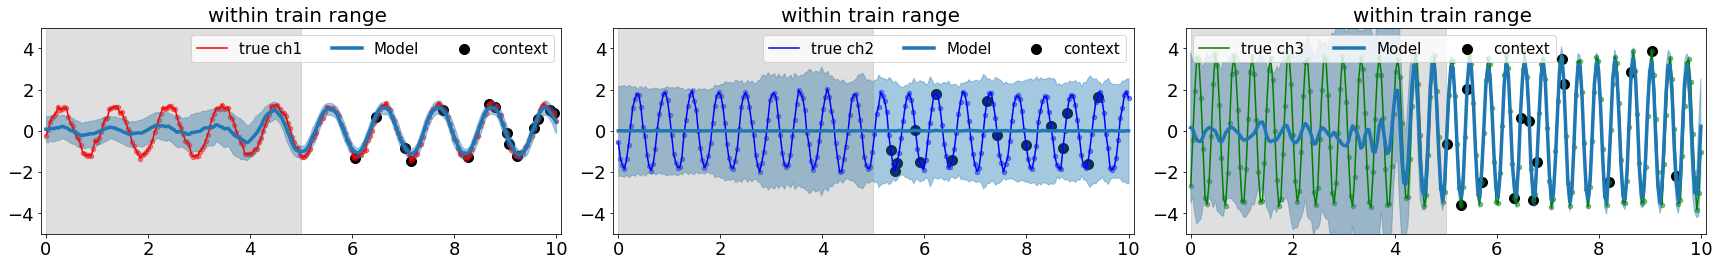

####################################################################################################


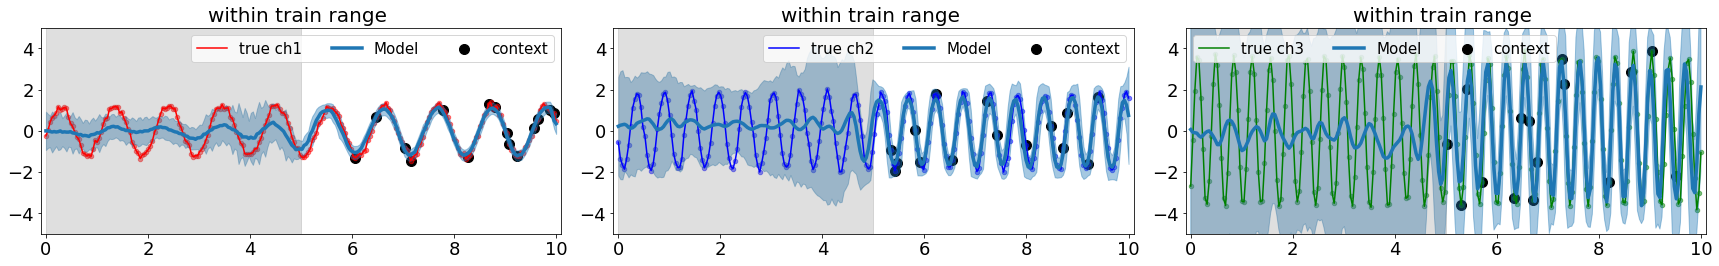

In [212]:
#xlim_ = [0-0.1,10+0.1]

figsiz_ = (24,3.8)

train_range = gen_cls.train_range
test_range = gen_cls.test_range
nbatch=2
#xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
#ylim_ = [-2,2]
ylim_ = [-5,5]

fontsiz_ = 15
fontsiz__ = 18

#------------------------------------------------------
# intrain context
#------------------------------------------------------


#gen_cls.testtype = 'extra'
gen_cls.testtype = testtype
context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range,
                                                                         test_range = test_range,                                                                         
                                                                         noise_true=True,
                                                                         intrain = False)


model_convcnp.eval()
model_tmp.eval()


y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1,0],y_std1.cpu().data.numpy()[1,0]


context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()


####################################################################################################


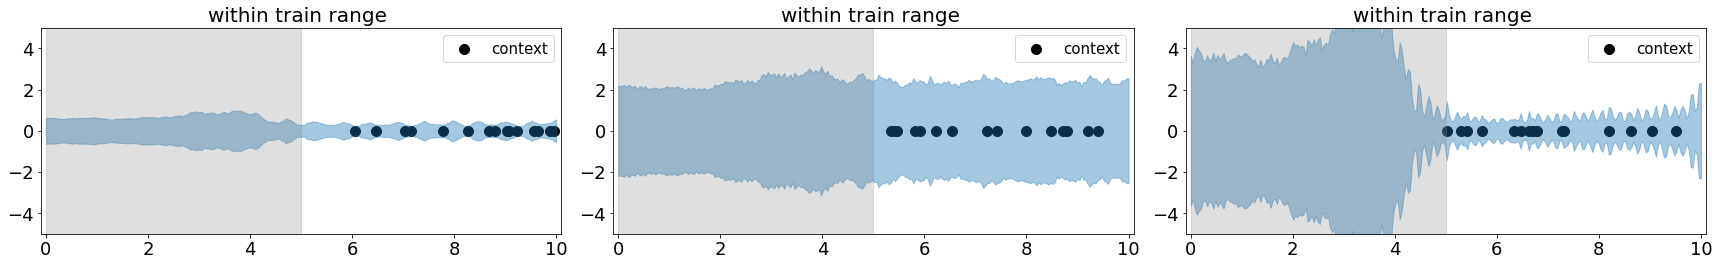

####################################################################################################


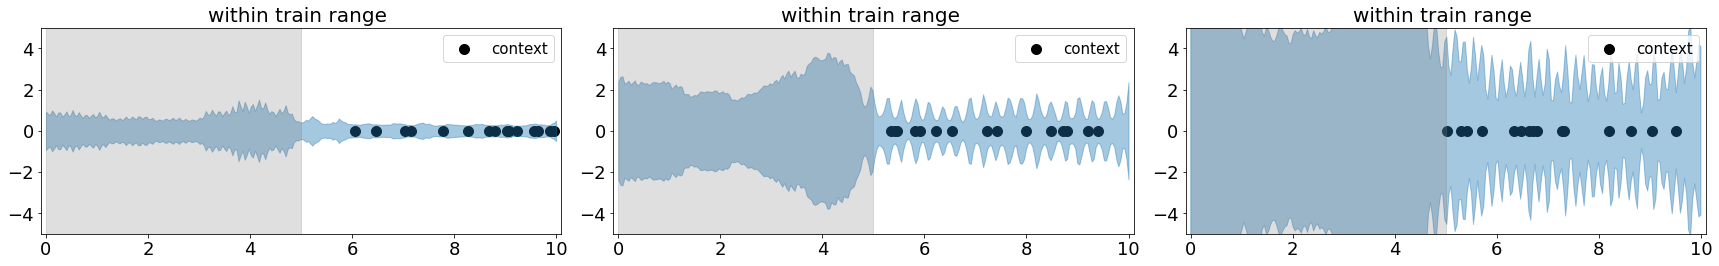

In [213]:
#xlim_ = [0-0.1,10+0.1]

figsiz_ = (24,3.8)

# train_range = gen_cls.train_range
# test_range = gen_cls.test_range
# nbatch=2
# #xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
# xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
# #ylim_ = [-2,2]
# #ylim_ = [-5,5]

# fontsiz_ = 15
# fontsiz__ = 18

# #------------------------------------------------------
# # intrain context
# #------------------------------------------------------


# #gen_cls.testtype = 'extra'
# # gen_cls.testtype = testtype
# # context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
# #                                                                          ncontext=ncontext,
# #                                                                          ntarget=ntarget,
# #                                                                          train_range = train_range,
# #                                                                          test_range = test_range,                                                                         
# #                                                                          noise_true=False,
# #                                                                          intrain = False)


# model_convcnp.eval()
# model_tmp.eval()

# y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
# y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
# #y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
# #y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


# y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
# y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0],y_std1.cpu().data.numpy()[0]



# context_x_1 = context_x.cpu().data.numpy()[0]
# context_y_1 = context_y.cpu().data.numpy()[0]
# target_x_1 = target_x.cpu().data.numpy()[0]
# target_y_1 = target_y.cpu().data.numpy()[0]
# full_x_1 = full_x.cpu().data.numpy()[0]
# full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        #plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        #plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        #plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0*y_mean[:,j] + 2 * y_std[:,j],
                         0*y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0*y_mean[:,j] + 2 * y_std[:,j],
                         0*y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()


In [214]:
# #gen_cls.testtype = testtype
# # context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
# #                                                                          ncontext=ncontext,
# #                                                                          ntarget=ntarget,
# #                                                                          train_range = train_range,
# #                                                                          test_range = test_range,                                                                         
# #                                                                          noise_true=False,
# #                                                                          intrain = False)



# model_convcnp.eval()
# model_tmp.eval()


# y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[1],y_std0.cpu().data.numpy()[1]
# y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1],y_std1.cpu().data.numpy()[1]



# context_x_1 = context_x.cpu().data.numpy()[1]
# context_y_1 = context_y.cpu().data.numpy()[1]
# target_x_1 = target_x.cpu().data.numpy()[1]
# target_y_1 = target_y.cpu().data.numpy()[1]
# full_x_1 = full_x.cpu().data.numpy()[1]
# full_y_1 = full_y.cpu().data.numpy()[1]


# print('#'*100)
# y_mean,y_std = y_mean0_1,y_std0_1

# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        

#         #dataset
#         plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          y_mean[:,j] + 2 * y_std[:,j],
#                          y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)

        
        
        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()






# print('#'*100)
# y_mean,y_std = y_mean1_1,y_std1_1
# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
# #         plt.scatter(context_x[:,j],context_y[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         plt.plot(full_x[:,j],full_y[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         plt.scatter(full_x[:,j],full_y[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #         plt.plot(full_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# #         plt.fill_between(full_x[:,j],
# #                          y_mean[:,j] + 2 * y_std[:,j],
# #                          y_mean[:,j] - 2 * y_std[:,j],
# #                          color='tab:blue', alpha=alpha_)
        
#         plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          y_mean[:,j] + 2 * y_std[:,j],
#                          y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()


## full range

####################################################################################################


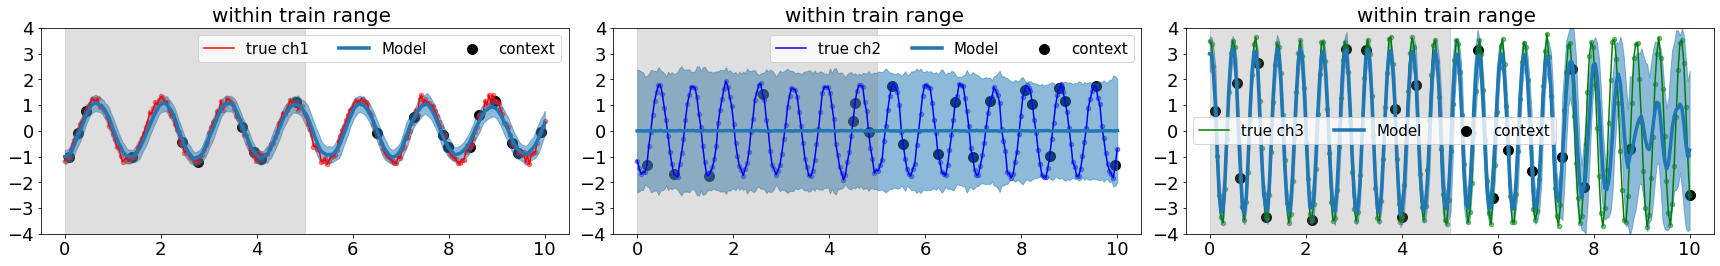

####################################################################################################


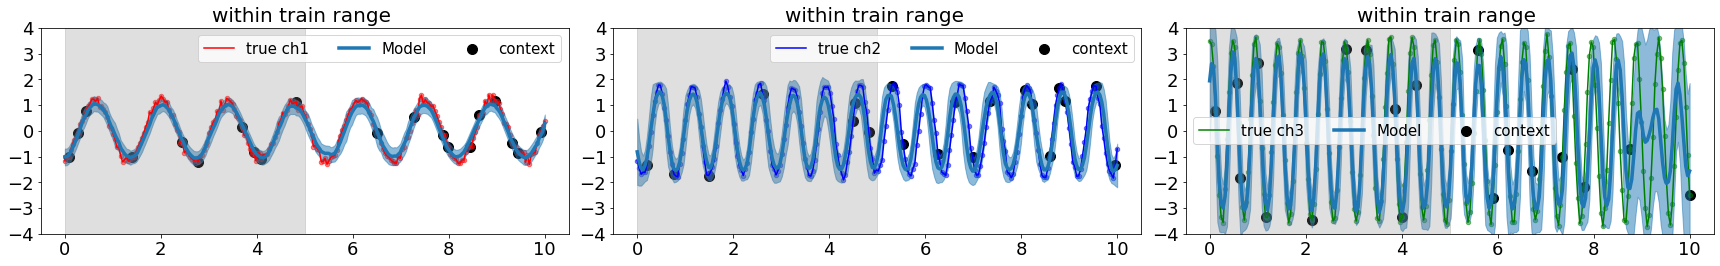

In [225]:
#------------------------------------------------------
#intrain context
#------------------------------------------------------
#ncontext,ntarget = 10,100
#gen_cls.testtype = 'extra_all'
nbatch=2
#ncontext,ntarget = 25,100
ncontext,ntarget = 20,50


gen_cls.testtype = testtype[:-1]
context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range,
                                                                         test_range = test_range, 
                                                                         noise_true = True,
                                                                         intrain = False)


model_convcnp.eval()
model_tmp.eval()

y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1,0],y_std1.cpu().data.numpy()[1,0]



context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




####################################################################################################


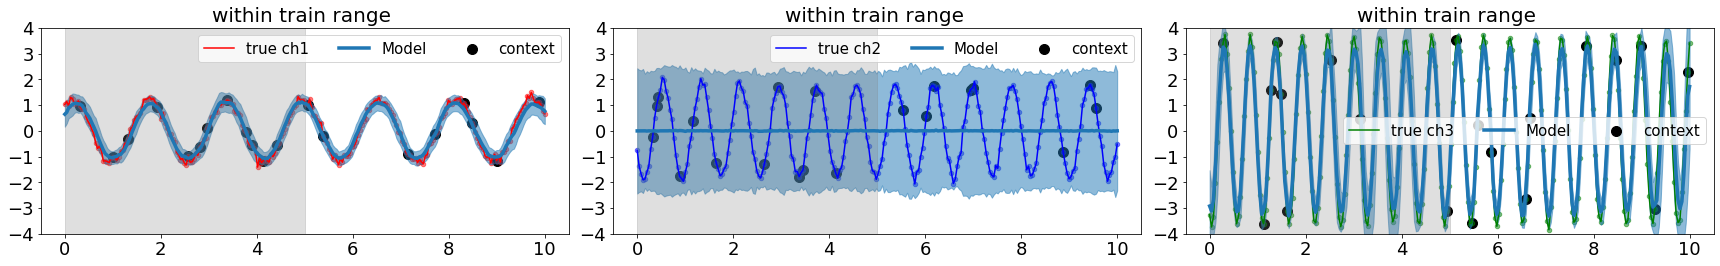

####################################################################################################


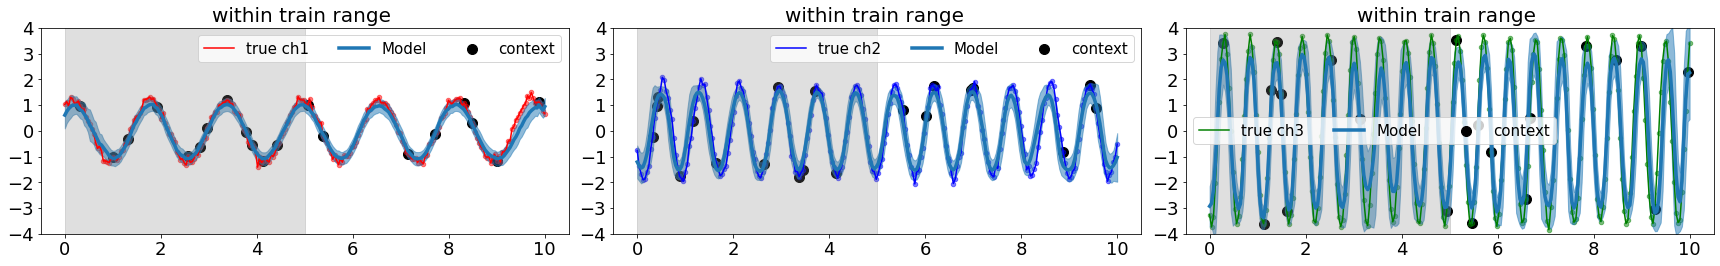

In [226]:
# gen_cls.testtype = testtype[:-1]
# context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
#                                                                          ncontext=ncontext,
#                                                                          ntarget=ntarget,
#                                                                          train_range = train_range,
#                                                                          test_range = test_range, 
#                                                                          noise_true = False,
#                                                                          intrain = False)



model_convcnp.eval()
model_tmp.eval()


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[1],y_std0.cpu().data.numpy()[1]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1,1],y_std1.cpu().data.numpy()[1,1]


context_x_1 = context_x.cpu().data.numpy()[1]
context_y_1 = context_y.cpu().data.numpy()[1]
target_x_1 = target_x.cpu().data.numpy()[1]
target_y_1 = target_y.cpu().data.numpy()[1]
full_x_1 = full_x.cpu().data.numpy()[1]
full_y_1 = full_y.cpu().data.numpy()[1]



nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




####################################################################################################


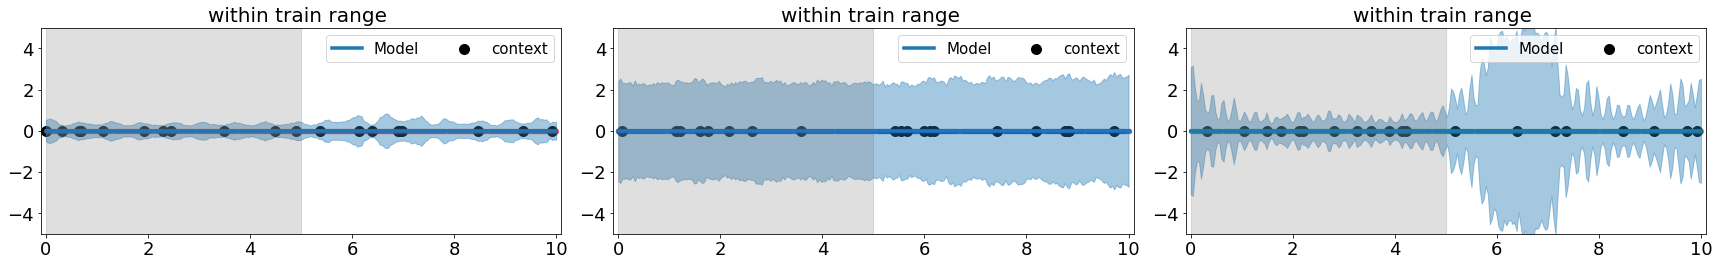

####################################################################################################


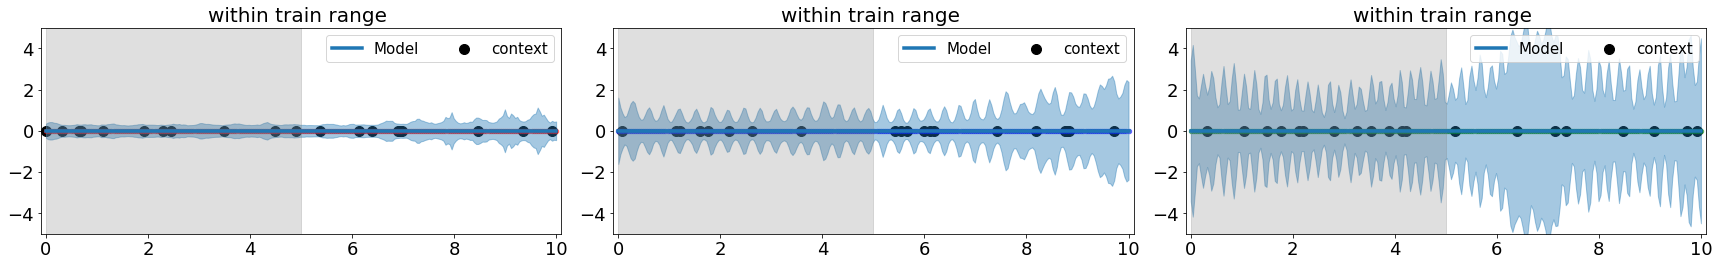

In [217]:
# gen_cls.testtype = testtype[:-1]
# context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
#                                                                          ncontext=ncontext,
#                                                                          ntarget=ntarget,
#                                                                          train_range = train_range,
#                                                                          test_range = test_range, 
#                                                                          noise_true = False,
#                                                                          intrain = False)



# model_convcnp.eval()
# model_tmp.eval()


# y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[1],y_std0.cpu().data.numpy()[1]
# y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1],y_std1.cpu().data.numpy()[1]


# context_x_1 = context_x.cpu().data.numpy()[1]
# context_y_1 = context_y.cpu().data.numpy()[1]
# target_x_1 = target_x.cpu().data.numpy()[1]
# target_y_1 = target_y.cpu().data.numpy()[1]
# full_x_1 = full_x.cpu().data.numpy()[1]
# full_y_1 = full_y.cpu().data.numpy()[1]



nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        


        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        #plt.plot(full_x_1[:,j],0*full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],0*full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],0*y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0*y_mean[:,j] + 2 * y_std[:,j],
                         0*y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        #plt.plot(full_x_1[:,j],0*full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],0*full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],0*y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0*y_mean[:,j] + 2 * y_std[:,j],
                         0*y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




In [56]:
KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    device=None,
    lr=1e-3,
    decay_lr=10,
    seed=123,
    batch_size=16,  # smaller batch because multiple samples
)



In [57]:
KWARGS 

{'is_retrain': False,
 'device': None,
 'lr': 0.001,
 'decay_lr': 10,
 'seed': 123,
 'batch_size': 16}

In [62]:
c = torch.randn(8,3,20)
a,b = c.split(10,-1)

In [83]:
#c = 0.0+torch.arange(16).reshape(2,2,2,2)
c = 0.0+torch.arange(8).reshape(2,2,2)

In [84]:
import operator
from functools import reduce


def prod(iterable):
    """Compute the product of all elements in an iterable."""
    return reduce(operator.mul, iterable, 1)

def pool_and_replicate_middle(t):
    """Mean pools a tensor on all but the first and last dimension (i.e. all the middle dimension)."""
    first, *middle, last = t.shape

    # size = [first, 1, last]
    t = t.view(first, prod(middle), last).mean(1, keepdim=True)

    t = t.view(first, *([1] * len(middle)), last)
    t = t.expand(first, *middle, last)

    # size = [first, *middle, last]
    return t

In [85]:
c_global = pool_and_replicate_middle(c)

In [86]:
c_global

tensor([[[1., 2.],
         [1., 2.]],

        [[5., 6.],
         [5., 6.]]])

In [87]:
first, *middle, last = c.shape

first,middle,last

(2, [2], 2)

In [89]:
c[0,:,0]


tensor([0., 2.])

In [91]:
c[0]

tensor([[0., 1.],
        [2., 3.]])

In [95]:
def channels_to_2nd_dim(X):
    """
    Takes a signal with channels on the last dimension (for most operations) and
    returns it with channels on the second dimension (for convolutions).
    """
    return X.permute(*([0, X.dim() - 1] + list(range(1, X.dim() - 1))))


def channels_to_last_dim(X):
    """
    Takes a signal with channels on the second dimension (for convolutions) and
    returns it with channels on the last dimension (for most operations).
    """
    return X.permute(*([0] + list(range(2, X.dim())) + [1]))


In [96]:
c= torch.randn(16,100,3)

c1 = channels_to_2nd_dim(c)
c2 = channels_to_last_dim(c1)

In [98]:
#c2-c
c2.size(),c.size()

(torch.Size([16, 100, 3]), torch.Size([16, 100, 3]))